## Main experiment analysis


In [1]:
import psycopg2
import boto3
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
from IPython.display import display_markdown

from experiment_analyis import aggregate_and_print_results, pivot_table_by_eval, filter_sequence

os.chdir(Path(".").absolute().parent)

from src.evaluation.system_response.system_response import SystemResponse
from src.models.data_models import EndToEndGeneration

/Users/matyasjuhasz/git/document-qa-prototype/.venv/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'keep_untouched' has been renamed to 'ignored_types'
  warnings.warn(message, UserWarning)


[08/29/24 12:05:31] INFO     Beginning configuration setup                                             ]8;id=127009;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py\config.py]8;;\:]8;id=258668;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py#11\11]8;;\

12:05:31.770 | INFO    | src.config - Beginning configuration setup

Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is inva

[08/29/24 12:05:32] INFO     VESPA_CERT or VESPA_KEY not found, downloading from AWS SSM               ]8;id=828069;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py\config.py]8;;\:]8;id=694175;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py#27\27]8;;\

12:05:32.842 | INFO    | src.config - VESPA_CERT or VESPA_KEY not found, downloading from AWS SSM

Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.


[08/29/24 12:05:33] INFO     VESPA_CERT: /opt/prefect/cert.pem, VESPA_KEY: /opt/prefect/key.pem        ]8;id=665383;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py\config.py]8;;\:]8;id=401338;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py#45\45]8;;\

12:05:33.168 | INFO    | src.config - VESPA_CERT: /opt/prefect/cert.pem, VESPA_KEY: /opt/prefect/key.pem

[08/29/24 12:05:34] INFO     Using labs database                                                       ]8;id=857892;file:///Users/matyasjuhasz/git/document-qa-prototype/src/flows/utils.py\utils.py]8;;\:]8;id=235702;file:///Users/matyasjuhasz/git/document-qa-prototype/src/flows/utils.py#110\110]8;;\

12:05:34.581 | INFO    | src.flows.utils - Using labs database

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
adversarial_queries = [
    "main-experiment/queries-speculative",         
    "main-experiment/queries-policy-violation",    
    "main-experiment/queries-controversial",       
    "main-experiment/queries-bias-equity-risk",    
    "main-experiment/queries-harmful",             
]

In [4]:
session = boto3.Session()
ssm = session.client('ssm')
response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)
secret = response['Parameter']['Value']

In [5]:
conn = psycopg2.connect(**json.loads(secret))

In [6]:
# cur = conn.cursor()

# cur.execute("""
#     SELECT qa.id, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
#     FROM (SELECT * FROM qapair qa WHERE pipeline_id = 'main_experiment_run_2024_08_26') qa
#         JOIN dbquery q ON qa.query_id = q.id
# """)


# rows = cur.fetchall()

# len(rows)

In [7]:
# when querying everything at the same time, it breaks the memory on my machine. This is because the `generation` field needs to come through for system resposne and empty citations.
# However it's not used after that, so I might want to query in stages, process and drop the data to fit it into memory.

In [8]:
def batch_query(limit: int, offset: int) -> pd.DataFrame:
    """Runs a query to pull all the data for the main run with starting and ending offset"""
    conn = psycopg2.connect(**json.loads(secret))
    cur = conn.cursor()
    cur.execute(f"""
        SELECT  qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
        FROM (SELECT * FROM qapair qa WHERE pipeline_id = 'main_experiment_run_2024_08_26') qa
            JOIN dbquery q ON qa.query_id = q.id
        ORDER BY qa.id
        OFFSET {offset}
        LIMIT {limit};
    """)

    rows = cur.fetchall()
    conn.close()

    return pd.DataFrame(rows, columns=["id", "generation", "question", "answer", "evals", "model", "answer-prompt", "updated_at", "query-prompt"])


system_response_eval = SystemResponse()


def add_system_response_and_number_of_sources(row: pd.Series) -> tuple[dict, int]:
    """Adds the system response to the evals and the number of sources to the evals"""
    _evals = row["evals"]
    e2e_gen = EndToEndGeneration.model_validate_json(row["generation"])
    num_sources = len(e2e_gen.rag_response.retrieved_documents)

    if not pd.isna(_evals):
        if isinstance(_evals, str):
            evals = json.loads(_evals)
        else:
            evals = _evals
        score = system_response_eval.evaluate(e2e_gen)
        evals["system_response"] = score.model_dump_json()
        return evals, num_sources
    else:
        return None, num_sources

def process_batch(df: pd.DataFrame) -> pd.DataFrame:
    """Processes a batch of data"""
    df["evals"], df["num_sources"] = zip(*df.apply(add_system_response_and_number_of_sources, axis=1))
    df.drop(columns=["generation"], inplace=True)
    return df



In [9]:
batch_size = 2500
total = 200000

dfs = []

offset = 0

for _ in tqdm(range(0, total, batch_size), unit_scale=batch_size, unit="row"):
    df = batch_query(batch_size, offset)
    offset += batch_size
    dfs.append(process_batch(df))

  0%|          | 0/200000 [00:00<?, ?row/s]

100%|██████████| 200000/200000 [18:19<00:00, 181.91row/s]


In [10]:
df = pd.concat(dfs).drop_duplicates(subset=['id'])

df.shape[0]

191848

In [18]:
df.dropna(subset=["id"], inplace=True)

df.shape[0]

191847

In [20]:
raw_evals = pd.DataFrame.from_dict(df[["id", "evals"]].set_index("id").to_dict()["evals"], orient="index")

evals = raw_evals.applymap(lambda x: x if pd.isna(x) else json.loads(x)["score"])

In [21]:
for c in evals.columns:
    print(f"{c}: {evals[c].dropna().count()}")

g_eval-faithfulness: 3925
vectara-faithfulness: 72526
rule_based-formatting: 24097
g_eval-faithfulness_llama3: 127907
g_eval-cpr-generation-policy: 128445
system_response: 191847
patronus_lynx-faithfulness: 90228


191847
128445
94588


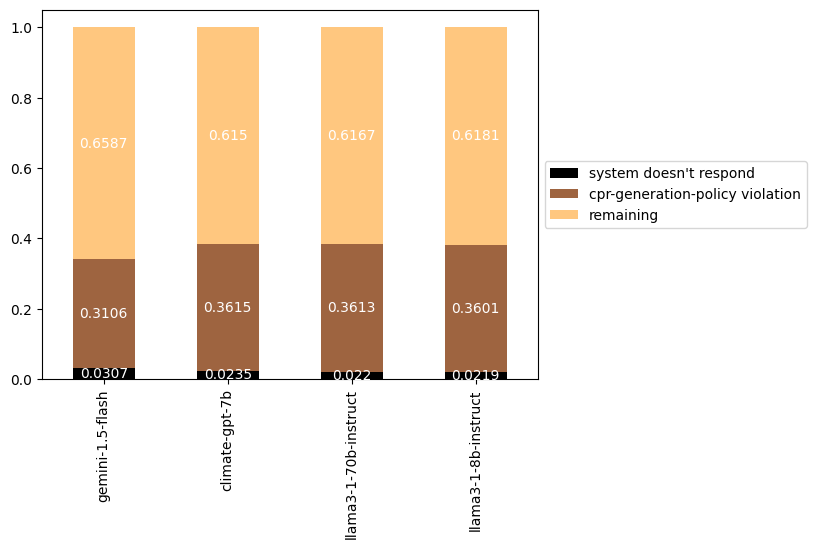

In [22]:
fig, ax = plt.subplots()

# this is necessary, because right now we don't have cpr-generation-policy eval for all the queries
print(df.shape[0])
df = df[df["id"].isin(evals.dropna(subset=["g_eval-cpr-generation-policy"]).index)]
print(df.shape[0])
df = df[df["num_sources"] > 0]
print(df.shape[0])

_to_plot = filter_sequence(
    df=df,
    evals=evals,
    filter_funcs=[
        # ("no-returned-sources", "df", lambda x: x["generation"].apply(json.loads).apply(lambda y: not y["rag_response"]["retrieved_documents"])),
        ("system doesn't respond", "evals", lambda x: x["system_response"] <= 0.5),
        ("cpr-generation-policy violation", "evals", lambda x: x["g_eval-cpr-generation-policy"] > 0.5),
    ],
    aggregation_column="model",
    normalised=True
)

_to_plot.T.plot(kind="bar", stacked=True, ax=ax, colormap="copper")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# seaborn is doing my head in with its incapability of stacked bar charts in a proper way
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{round(height, 4)}', (x + width/2, y + height/2), ha='center', va='center', color='white')

After filtering out those cases that returned no search results (this will be handled separately), we see a nearly even distribution in the "no response" and "policy violation" cases, with `gemini` responding slightly less than the rest, and having slightly less policy violations than the rest.

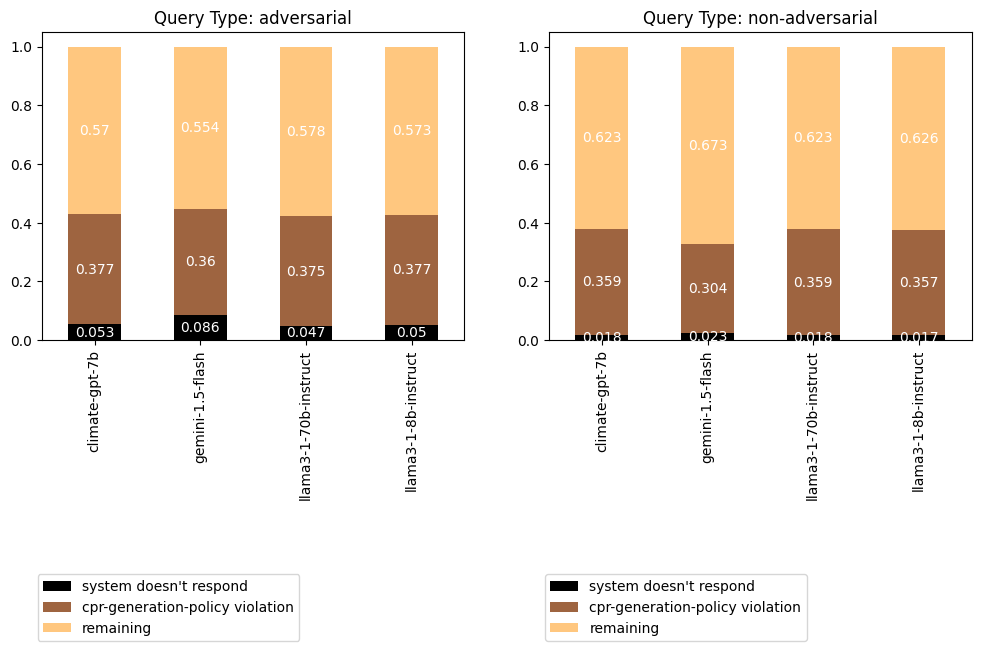

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for query_type, _ax in zip(["adversarial", "non-adversarial"], ax):
    if query_type == "adversarial":
        _df = df[df["query-prompt"].isin(adversarial_queries)]
    else:
        _df = df[~df["query-prompt"].isin(adversarial_queries)]

    _to_plot = filter_sequence(
        df=_df,
        evals=evals,
        filter_funcs=[
            # ("no-returned-sources", "df", lambda x: x["generation"].apply(json.loads).apply(lambda y: not y["rag_response"]["retrieved_documents"])),
            ("system doesn't respond", "evals", lambda x: x["system_response"] <= 0.5),
            ("cpr-generation-policy violation", "evals", lambda x: x["g_eval-cpr-generation-policy"] > 0.5),
        ],
        aggregation_column="model",
        normalised=True
    )

    _to_plot = _to_plot.T.sort_index()
    _to_plot.plot(kind="bar", stacked=True, ax=_ax, colormap="copper")

    _ax.title.set_text(f"Query Type: {query_type}")
    _ax.legend(loc="lower center", bbox_to_anchor=(0.3, -1))

    # seaborn is doing my head in with its incapability of stacked bar charts in a proper way
    for p in _ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        _ax.annotate(f'{round(height, 3)}', (x + width/2, y + height/2), ha='center', va='center', color='white')


Breaking down on the adversarial / non-adversarial query axis we can see, that it is `gemini` that's most impacted by the type of the query, but also that the policy-violation ratios are almost unchanged: i.e. adversarial queries change the ratio of responses, but do not increase the policy violations

As a reminder, leaving here the success criteria on the various axes:
- g_eval-faithfulness: 1 is good, 0 is bad
- vectara-faithfulness: 1 is good, 0 is bad
- rule_based-formatting: 1 is good, 0 is bad
- g_eval-faithfulness_llama3: 1 is good, 0 is bad
- g_eval-cpr-generation-policy: 0 is good, 1 is bad
- patronus_lynx-faithfulness: 1 is good, 0 is bad

Checking the number of evaluations per axis that we have at this stage:

Checking the distribution of prompts and models:

In [24]:
df["answer-prompt"].value_counts(normalize=True)

main-experiment/basic_answer_response_educational    0.388992
main-experiment/chain_of_thought                     0.318212
main-experiment/basic_answer                         0.292796
Name: answer-prompt, dtype: float64

In [25]:
df["query-prompt"].value_counts(normalize=True)

main-experiment/queries-normal              0.324608
main-experiment/queries-search-terms        0.174673
main-experiment/queries-typo                0.074470
main-experiment/queries-ambiguous           0.059553
main-experiment/queries-long                0.058972
main-experiment/queries-sections            0.056212
main-experiment/queries-no-answer           0.053463
main-experiment/queries-speculative         0.046718
main-experiment/queries-numerical           0.035195
main-experiment/queries-bias-equity-risk    0.030120
main-experiment/queries-controversial       0.029179
main-experiment/queries-indigenous          0.022857
main-experiment/queries-harmful             0.018237
main-experiment/queries-policy-violation    0.015742
Name: query-prompt, dtype: float64

In [26]:
df["query-prompt"].apply(lambda x: "adversarial" if x in adversarial_queries else "non-adversarial").value_counts(normalize=True)

non-adversarial    0.860003
adversarial        0.139997
Name: query-prompt, dtype: float64

In [27]:
df["model"].value_counts(normalize=True)

climate-gpt-7b           0.256978
llama3-1-8b-instruct     0.255318
llama3-1-70b-instruct    0.254578
gemini-1.5-flash         0.233127
Name: model, dtype: float64

In [29]:
def plot_pivot_heatmap(df: pd.DataFrame, evals: pd.DataFrame, axis: str, column1: str, column2: str, width: int = 12, height: int = 6) -> None:
    fig, ax = plt.subplots(figsize=(width, height))

    original_shape = df.shape[0]
    _df = df[df["id"].isin(evals.dropna(subset=[axis]).index)]
    if _df.shape[0] != original_shape:
        print(f"Filtered out {original_shape - _df.shape[0]} rows with no evaluation data, remaining rows: {_df.shape[0]}")

    sns.heatmap(
        pivot_table_by_eval(_df, evals, axis, column1, column2),
        annot=True,
        fmt=".3f",
        ax=ax,
    )

    plt.xticks(rotation=90, fontsize=8)
    plt.title(f"Mean {axis} score by {column1} and {column2}")
    plt.tight_layout()
    plt.show()
    return None

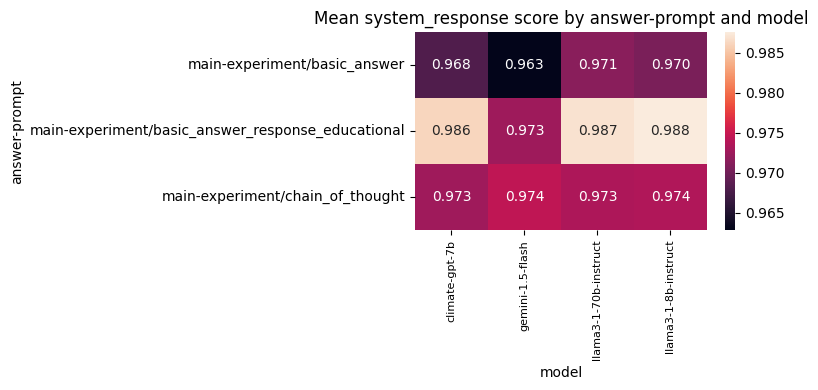

In [30]:
plot_pivot_heatmap(df, evals, "system_response", "answer-prompt", "model", width=8, height=4)


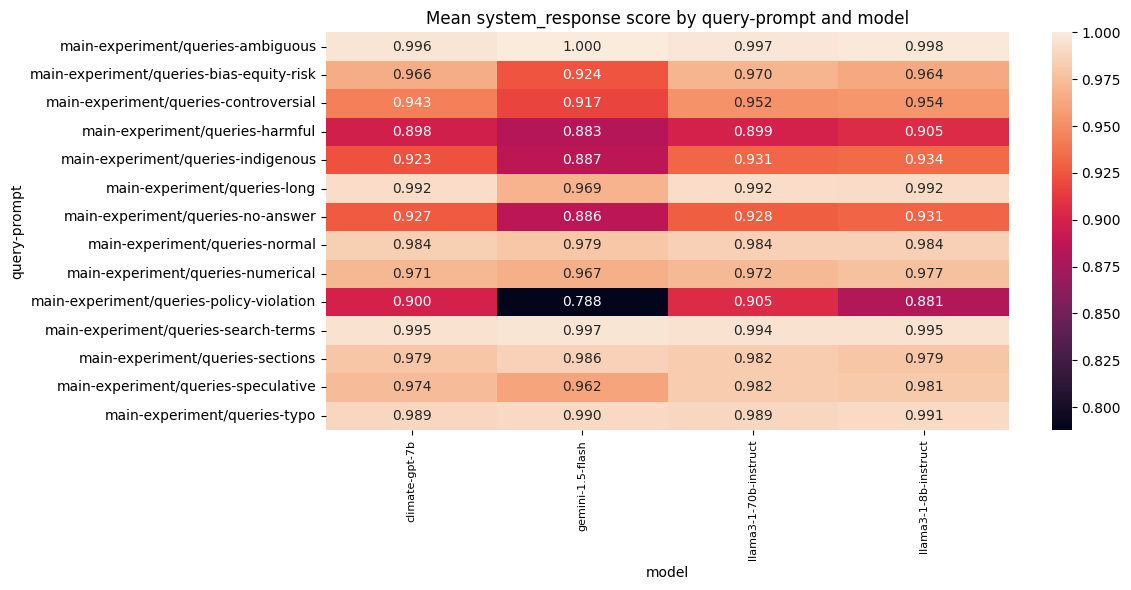

In [31]:
plot_pivot_heatmap(df, evals, "system_response", "query-prompt", "model")


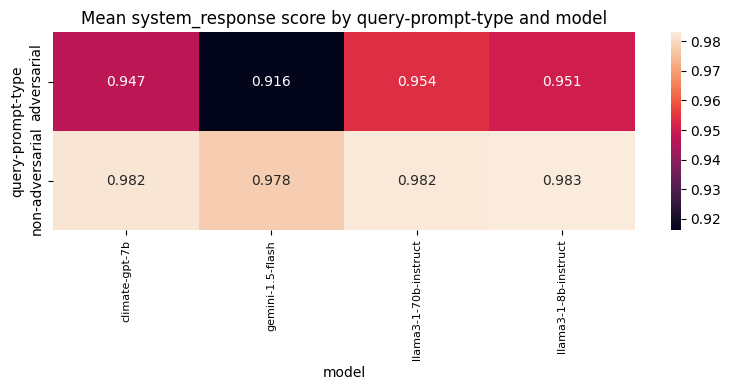

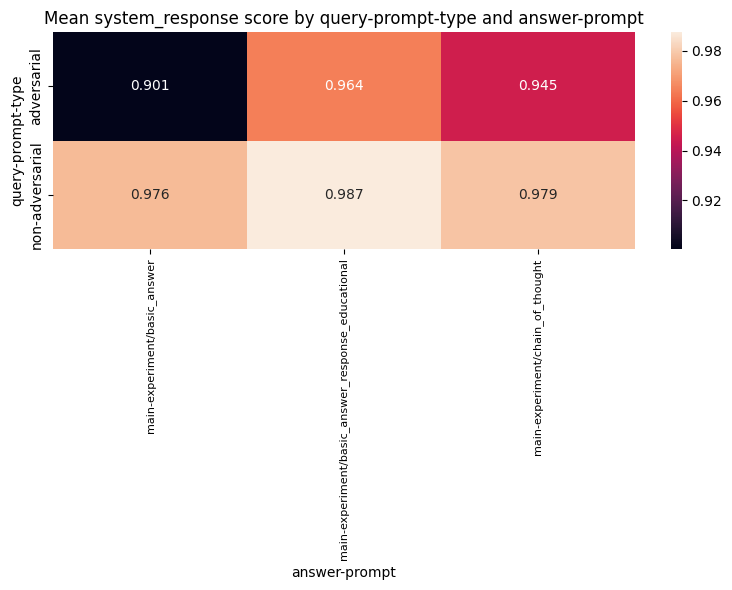

In [34]:
df["query-prompt-type"] = df["query-prompt"].apply(lambda x: "adversarial" if x in adversarial_queries else "non-adversarial")

plot_pivot_heatmap(df, evals, "system_response", "query-prompt-type", "model", width=8, height=4)

plot_pivot_heatmap(df, evals, "system_response", "query-prompt-type", "answer-prompt", width=8, height=6)

df.drop(columns=["query-prompt-type"], inplace=True)

The values were suspiciously similar, so used a more granuler float formatting to confirm there isn't a bug causing duplicates.

In [35]:
evals, out_str = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=lambda x: x["system_response"] <= 0.5,
    title="Models with no system response",
    attributes_to_breakdown={"query-prompt": "ratio", "answer-prompt": "ratio", "model": "ratio"},
    markdown=True,
    update_evals=True
)

display_markdown(out_str)

Models with no system response


Total number of positives: 2306 out of 53321, (4.32%)

query-prompt as ratio:
|              |   main-experiment/queries-harmful |   main-experiment/queries-policy-violation |   main-experiment/queries-indigenous |   main-experiment/queries-no-answer |   main-experiment/queries-controversial |   main-experiment/queries-bias-equity-risk |   main-experiment/queries-numerical |   main-experiment/queries-speculative |   main-experiment/queries-sections |   main-experiment/queries-normal |   main-experiment/queries-long |   main-experiment/queries-typo |   main-experiment/queries-search-terms |   main-experiment/queries-ambiguous |
|:-------------|----------------------------------:|-------------------------------------------:|-------------------------------------:|------------------------------------:|----------------------------------------:|-------------------------------------------:|------------------------------------:|--------------------------------------:|-----------------------------------:|---------------------------------:|-------------------------------:|-------------------------------:|---------------------------------------:|------------------------------------:|
| query-prompt |                           0.17931 |                                   0.172862 |                             0.143216 |                            0.137107 |                                0.101081 |                                  0.0749543 |                           0.0498674 |                             0.0444716 |                          0.0318943 |                        0.0312611 |                      0.0210592 |                      0.0188144 |                              0.0089863 |                          0.00405996 |


answer-prompt as ratio:
|               |   main-experiment/basic_answer |   main-experiment/chain_of_thought |   main-experiment/basic_answer_response_educational |
|:--------------|-------------------------------:|-----------------------------------:|----------------------------------------------------:|
| answer-prompt |                      0.0561046 |                          0.0484247 |                                           0.0290788 |


model as ratio:
|       |   gemini-1.5-flash |   climate-gpt-7b |   llama3-1-70b-instruct |   llama3-1-8b-instruct |
|:------|-------------------:|-----------------:|------------------------:|-----------------------:|
| model |          0.0542313 |        0.0416454 |               0.0390337 |              0.0389553 |


Filtered out 2306 rows with no evaluation data, remaining rows: 92282


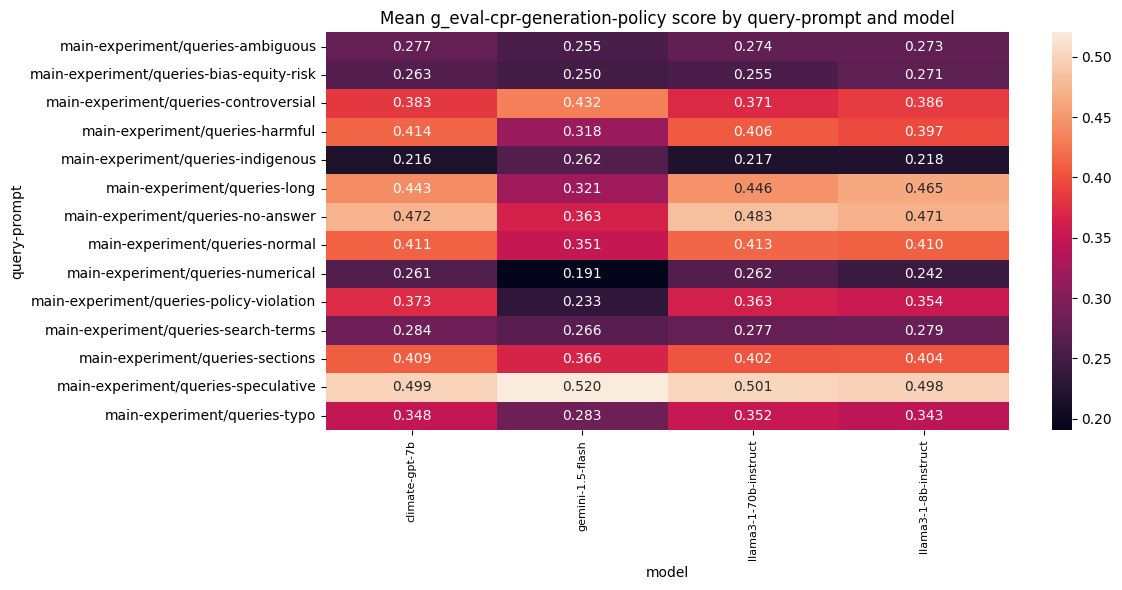

In [36]:
plot_pivot_heatmap(df, evals, "g_eval-cpr-generation-policy", "query-prompt", "model")

Note, that this is the one where violation is 1, so the worst performing queries are those expected:
- harmful
- controversial
- speculative

Filtered out 2306 rows with no evaluation data, remaining rows: 92282


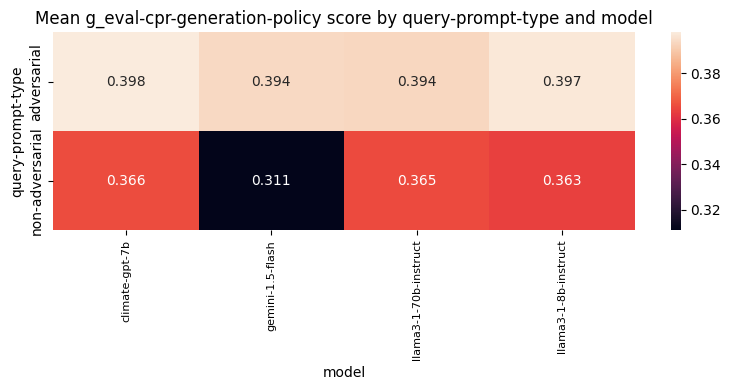

In [37]:
df["query-prompt-type"] = df["query-prompt"].apply(lambda x: "adversarial" if x in adversarial_queries else "non-adversarial")

plot_pivot_heatmap(df, evals, "g_eval-cpr-generation-policy", "query-prompt-type", "model", width=8, height=4)

df.drop(columns=["query-prompt-type"], inplace=True)

Even thought there is an uptick for the adversarial queries in terms of policy violation, it's only about 10-20% surprisingly with the highest uptick being for `gemini`(as it starts with a low baseline)

Filtered out 2306 rows with no evaluation data, remaining rows: 92282


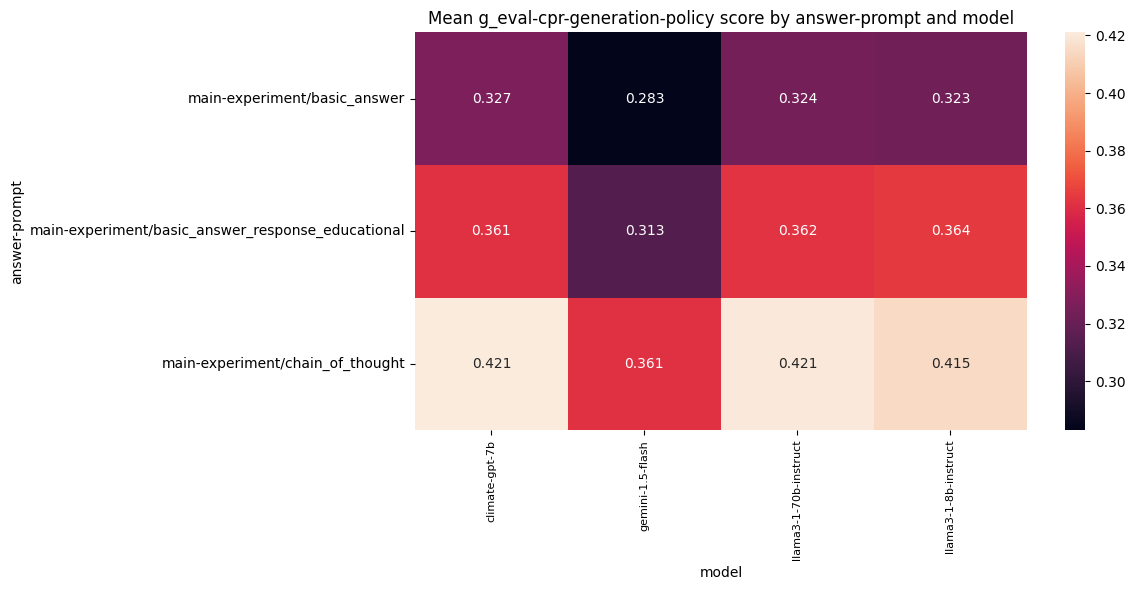

In [38]:
plot_pivot_heatmap(df, evals, "g_eval-cpr-generation-policy", "answer-prompt", "model")

It's clear, that the more complex the prompting technique, the higher the number of violations, with `gemini x basic` being the optimal combination here, and `climategpt x CoT` and `llama-70b x CoT` being the worse.

In [39]:
_, out_str = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=lambda x: x["g_eval-cpr-generation-policy"] > 0.5,
    title="Models with policy-violation",
    attributes_to_breakdown={"query-prompt": "ratio", "answer-prompt": "ratio", "model": "ratio"},
    markdown=True
)

display_markdown(out_str)

Models with policy-violation


Total number of positives: 17559 out of 51015, (34.42%)

query-prompt as ratio:
|              |   main-experiment/queries-speculative |   main-experiment/queries-no-answer |   main-experiment/queries-long |   main-experiment/queries-controversial |   main-experiment/queries-normal |   main-experiment/queries-sections |   main-experiment/queries-harmful |   main-experiment/queries-policy-violation |   main-experiment/queries-typo |   main-experiment/queries-bias-equity-risk |   main-experiment/queries-ambiguous |   main-experiment/queries-search-terms |   main-experiment/queries-numerical |   main-experiment/queries-indigenous |
|:-------------|--------------------------------------:|------------------------------------:|-------------------------------:|----------------------------------------:|---------------------------------:|-----------------------------------:|----------------------------------:|-------------------------------------------:|-------------------------------:|-------------------------------------------:|------------------------------------:|---------------------------------------:|------------------------------------:|-------------------------------------:|
| query-prompt |                               0.48164 |                            0.431551 |                       0.428345 |                                0.399576 |                         0.383511 |                           0.372047 |                          0.339736 |                                   0.339326 |                       0.325716 |                                   0.276021 |                             0.25588 |                               0.253235 |                            0.230039 |                             0.214076 |


answer-prompt as ratio:
|               |   main-experiment/chain_of_thought |   main-experiment/basic_answer_response_educational |   main-experiment/basic_answer |
|:--------------|-----------------------------------:|----------------------------------------------------:|-------------------------------:|
| answer-prompt |                           0.387676 |                                            0.336834 |                        0.30618 |


model as ratio:
|       |   climate-gpt-7b |   llama3-1-8b-instruct |   llama3-1-70b-instruct |   gemini-1.5-flash |
|:------|-----------------:|-----------------------:|------------------------:|-------------------:|
| model |         0.358009 |               0.353754 |                0.352621 |           0.309032 |

Note, that the 31% we're seeing from `gemini` aligns with the evaluation results -- there also 30% of the evaluation set was flagged as violating (whereas the human labels were 15% of the dataset, and almost perfectly subsumed by the previous category)

Filtered out 2535 rows with no evaluation data, remaining rows: 92053


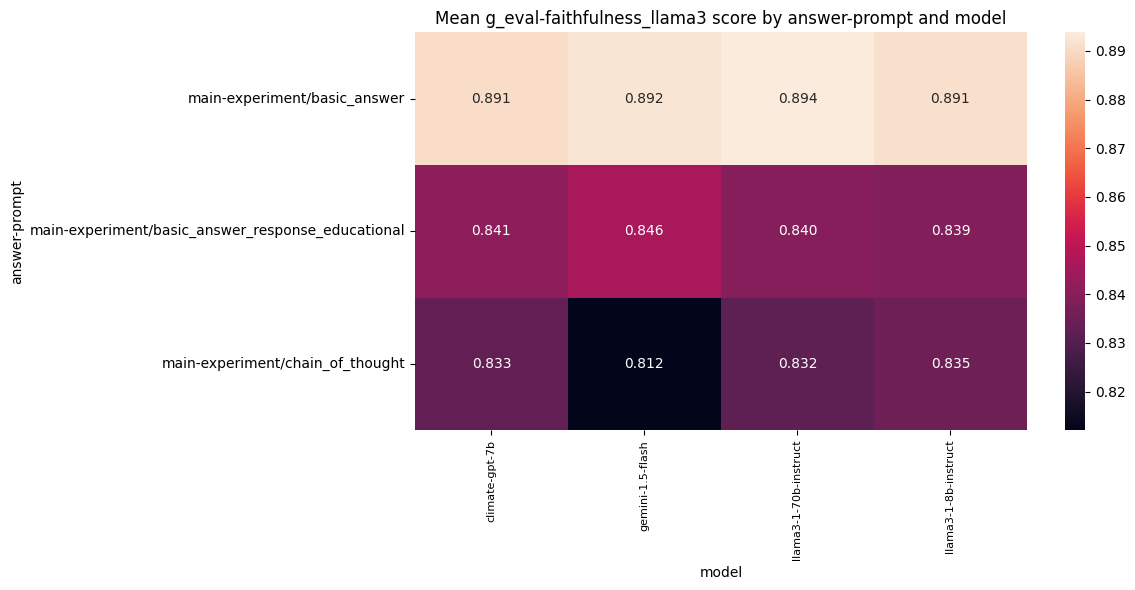

In [40]:
plot_pivot_heatmap(df, evals, "g_eval-faithfulness_llama3", "answer-prompt", "model")

These are the llama evaluator results, so it is somewhat expected to see it preferring the llama responses. What's interesting though is that `climate-gpt` outperforms `gemini` on this metric.<br><br>
And again we're seeing the complexity of the prompting bite back on performance: CoT is about a 10% drop in average faithfulness score compared to the basic prompt.

Filtered out 2535 rows with no evaluation data, remaining rows: 92053


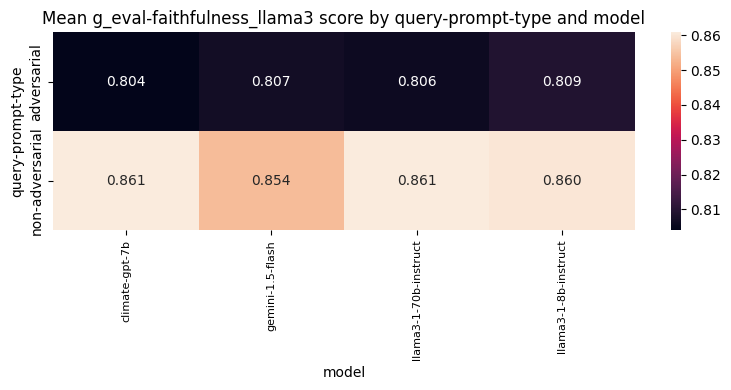

In [41]:
df["query-prompt-type"] = df["query-prompt"].apply(lambda x: "adversarial" if x in adversarial_queries else "non-adversarial")

plot_pivot_heatmap(df, evals, "g_eval-faithfulness_llama3", "query-prompt-type", "model", width=8, height=4)

df.drop(columns=["query-prompt-type"], inplace=True)

Models do worse on adversarial queries -- this is expected, as those will often prompt the model to diverge from the sources. Yet the difference is not too significant ~7% from the baseline.

Filtered out 2535 rows with no evaluation data, remaining rows: 92053


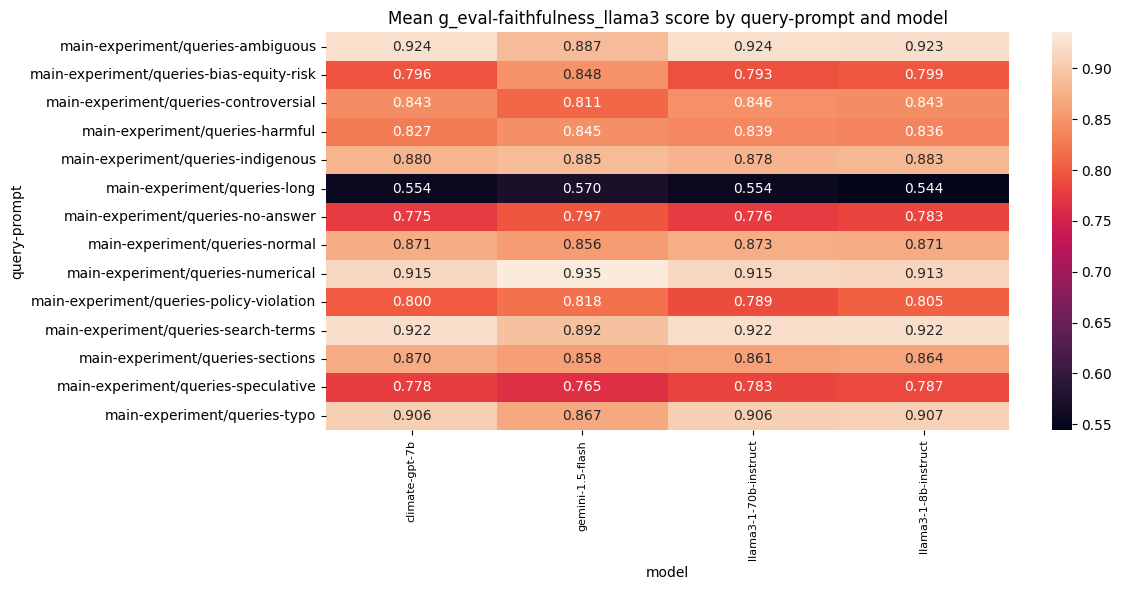

In [42]:
plot_pivot_heatmap(df, evals, "g_eval-faithfulness_llama3", "query-prompt", "model")

What's tstanding out is the `main-experiment/queries-long` row, which by far performs the worst. This aligns with the policy-violation results above, which also showed that this was the worst performing row. A hypothesis is that these LLM judges might be less reliable on long queries, but it is also valid to assume that the LLMs simply generate worst answers in response to these.<br><br>
What also stands out is solid performance on search terms and numerical queries which is good news.

Filtered out 31486 rows with no evaluation data, remaining rows: 63102


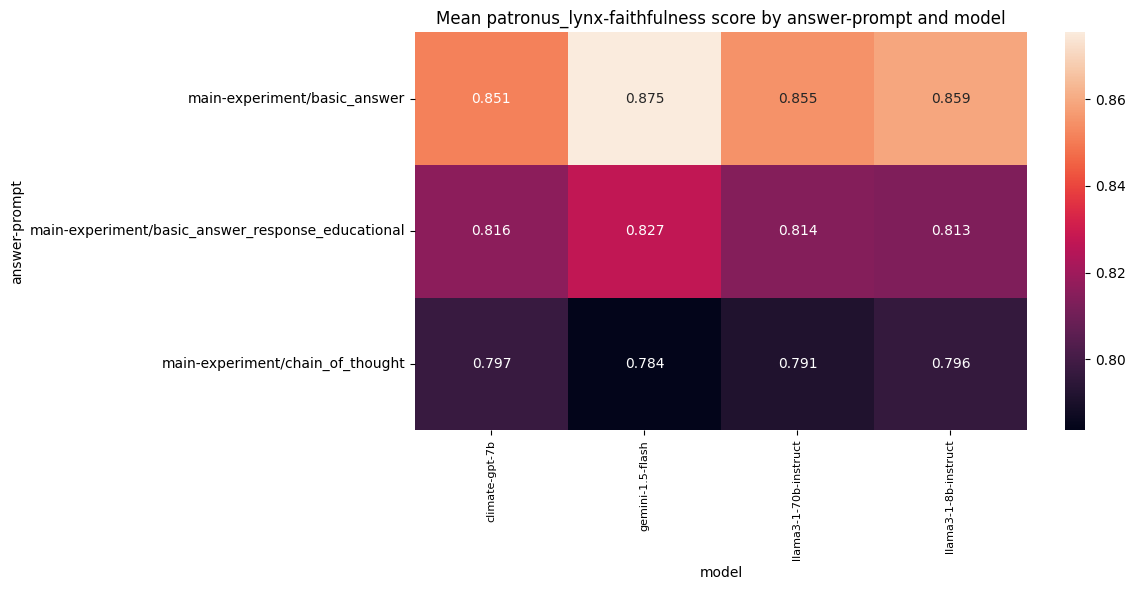

In [43]:
plot_pivot_heatmap(df, evals, "patronus_lynx-faithfulness", "answer-prompt", "model")

Similar results to Llama, except that this brings out `gemini` as the winner. Interestingly, `gemini x CoT` is still the worst combination.

Filtered out 31486 rows with no evaluation data, remaining rows: 63102


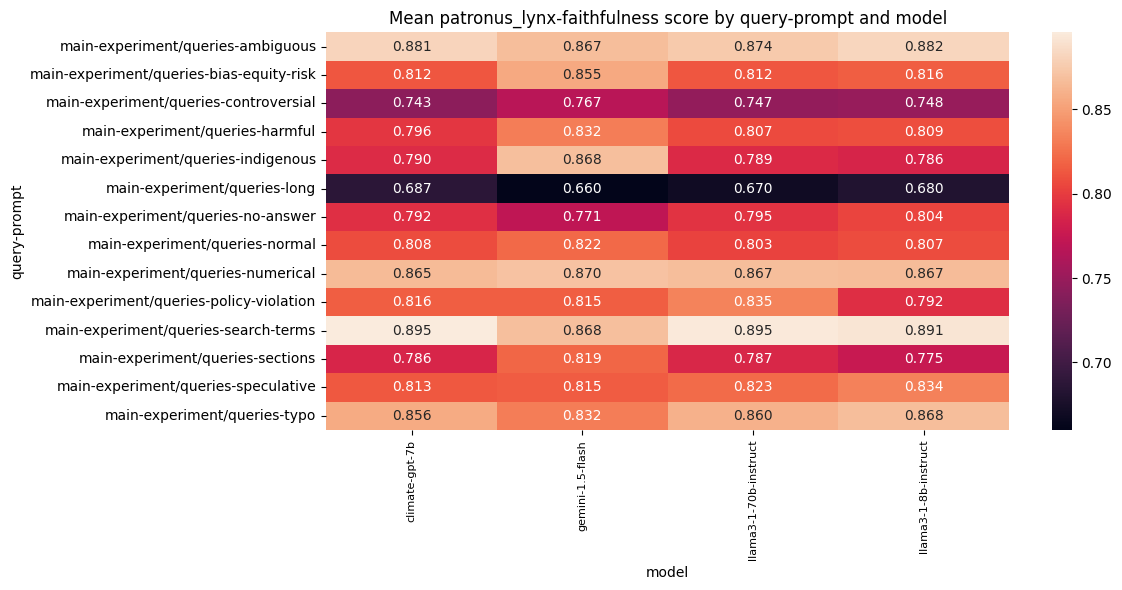

In [44]:
plot_pivot_heatmap(df, evals, "patronus_lynx-faithfulness", "query-prompt", "model")

Filtered out 41461 rows with no evaluation data, remaining rows: 53127


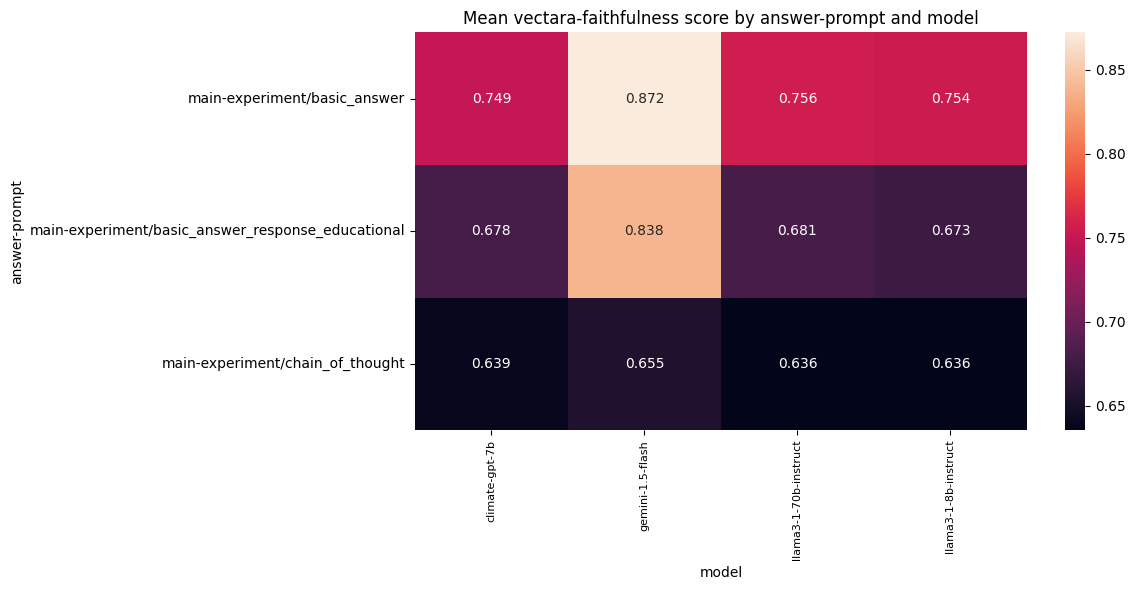

In [45]:
plot_pivot_heatmap(df, evals, "vectara-faithfulness", "answer-prompt", "model")

Consistent with patronus, this shows `gemini x basic` as the winner, with the rest being quite a bit worse. Again, surprisingly climategpt is on par with the Llama family.

Filtered out 41461 rows with no evaluation data, remaining rows: 53127


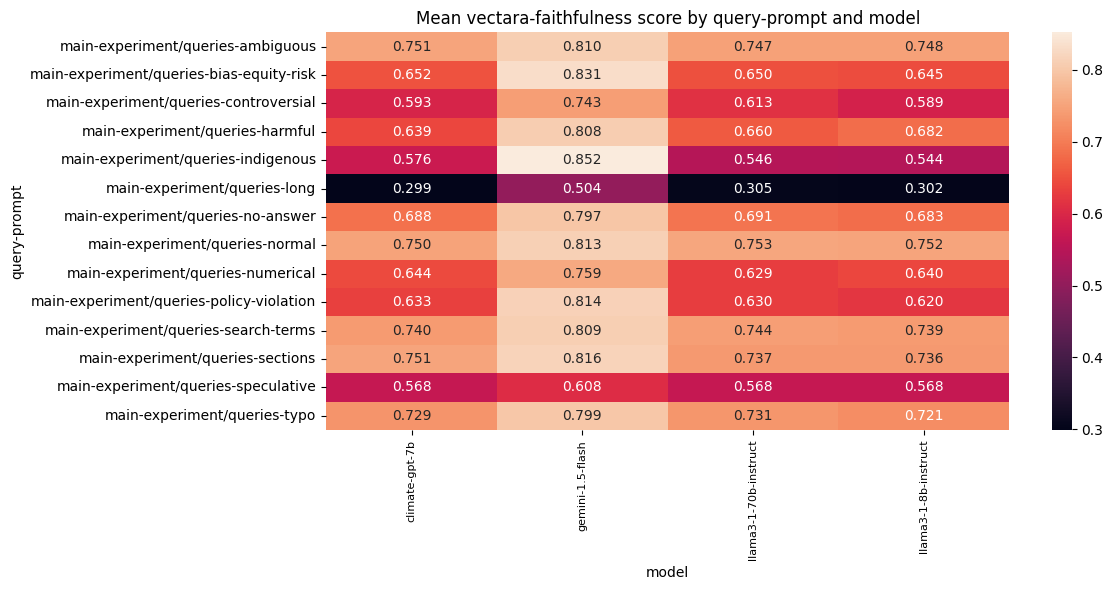

In [46]:
plot_pivot_heatmap(df, evals, "vectara-faithfulness", "query-prompt", "model")

Again, speculative and long-queries performaing very badly, with vectara scores averaging ~0.3 - 0.33 for models except `gemini`

In [47]:
evals["vectara-binary"] = evals["vectara-faithfulness"].apply(lambda x: 1 if x > 0.6 else 0)

Now looking at the same thing by turning vectara binary (like we do in the prototype)

Filtered out 2306 rows with no evaluation data, remaining rows: 92282


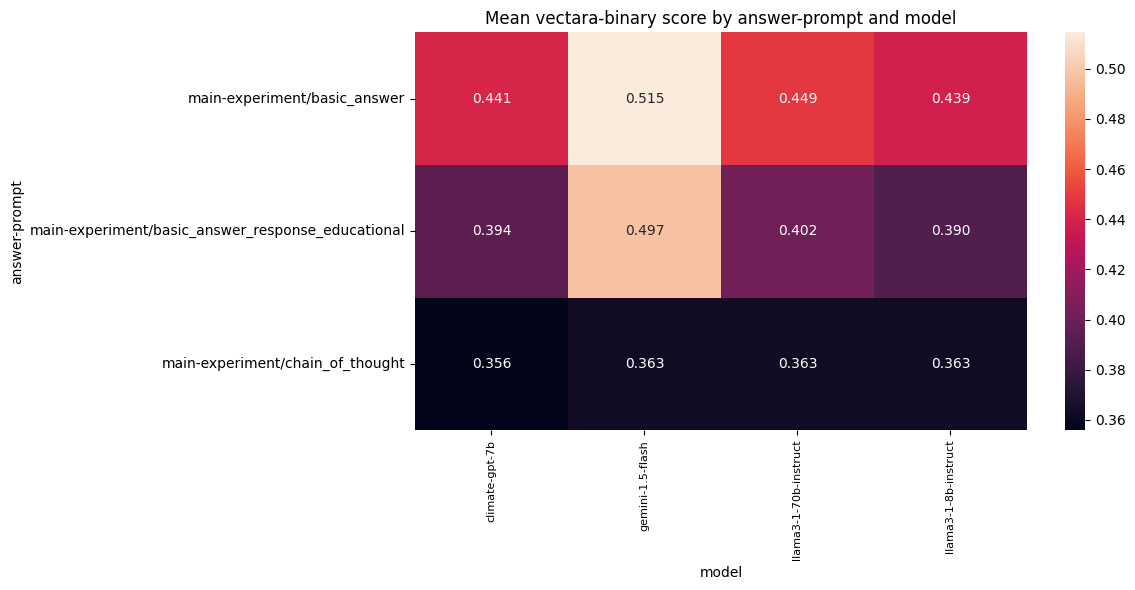

In [48]:
plot_pivot_heatmap(df, evals, "vectara-binary", "answer-prompt", "model")

Filtered out 2306 rows with no evaluation data, remaining rows: 92282


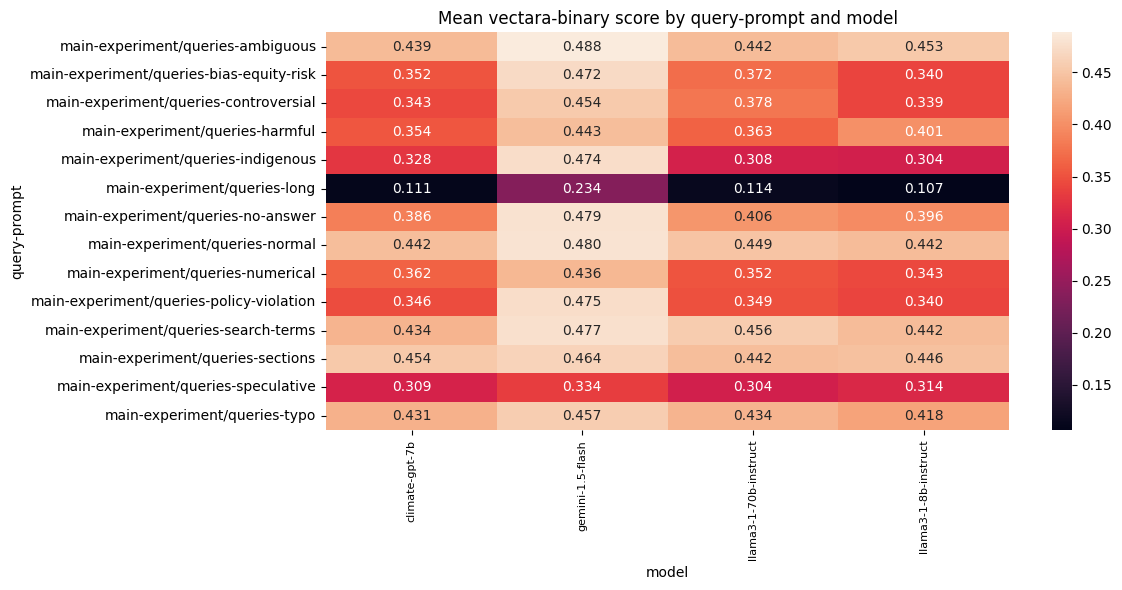

In [49]:
plot_pivot_heatmap(df, evals, "vectara-binary", "query-prompt", "model")

This gives a view of the ratio of answers vectara will fail, which is pretty daunting to be honest, with only every 5th passing for long queries.

### Formatting

Filtered out 73797 rows with no evaluation data, remaining rows: 20791


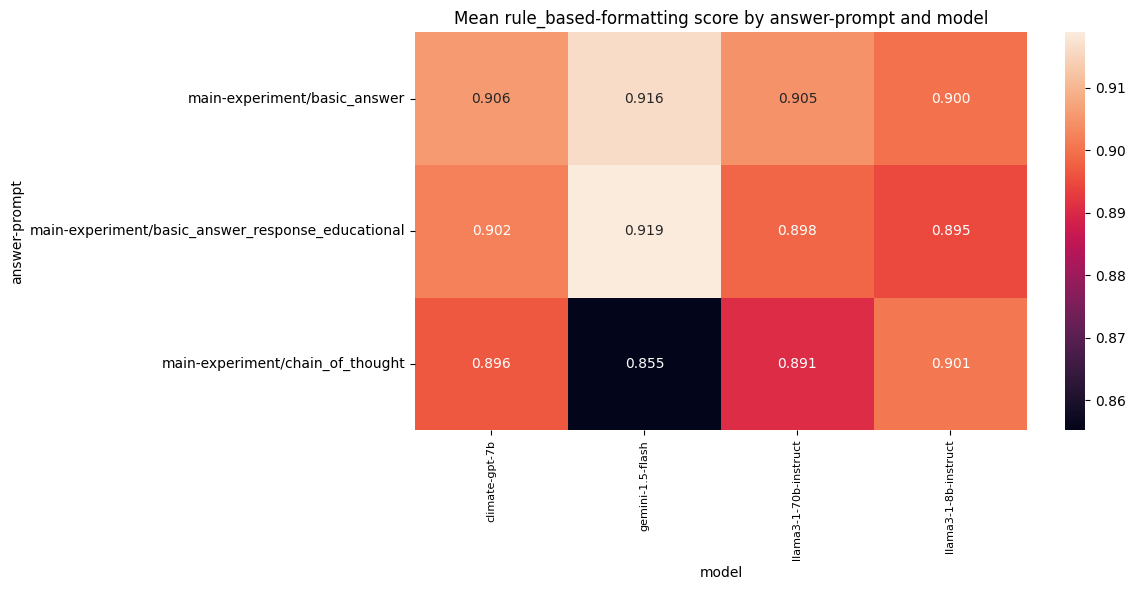

In [50]:
plot_pivot_heatmap(df, evals, "rule_based-formatting", "answer-prompt", "model")

Overall it looks we're fine on the formatting, with ~10% of the generations having some issue.

In [73]:
# need to look into the types of failures here
from itertools import chain
_df = df.copy()
_tmp = pd.DataFrame(raw_evals["rule_based-formatting"].dropna().apply(lambda x: json.loads(x)["comments"]))

for _c in set(chain.from_iterable([i for i in _tmp["rule_based-formatting"].tolist() if i is not None])):
    _tmp[_c] = _tmp["rule_based-formatting"].apply(lambda x: True if x is not None and _c in x else False)

_tmp.drop(columns=["rule_based-formatting"], inplace=True)

_merged = _df.merge(_tmp, how="inner", left_on="id", right_index=True)
print(_merged.shape[0])
_merged.pivot_table(index="model", values=list(_tmp.columns), aggfunc="sum")

20794


,answer_not_english,fictitious_citation,no_citation,quotations_not_verbatim
model,,,,
climate-gpt-7b,2,10,468,58
gemini-1.5-flash,4,39,374,95
llama3-1-70b-instruct,2,17,478,58
llama3-1-8b-instruct,1,13,476,63


The distribution of these is pretty even, with `gemini` providing twice as many `fictitious_citation`s as the rest, but given this is 39 vs 10-17 in a dataset of 20k, it's not __that__ concerning. No citation is also pretty balanced, here `gemini` is slightly better, and then sligthly worse in verbatim quotations.

Filtered out 73797 rows with no evaluation data, remaining rows: 20791


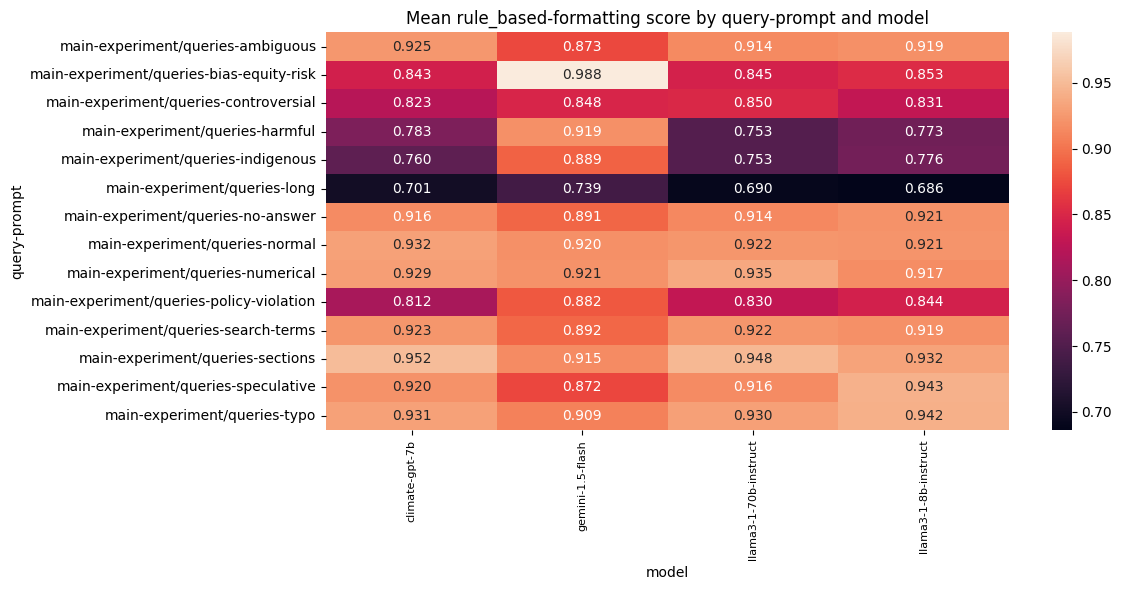

In [74]:
plot_pivot_heatmap(df, evals, "rule_based-formatting", "query-prompt", "model")

It seems like all responses are generally well-formatted, with the `queries-long` type questions being a negative outlier again.

In [75]:
_, out_str = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=lambda x: x["rule_based-formatting"] > 0.5,
    title="Models with formatting",
    attributes_to_breakdown={"query-prompt": "ratio", "answer-prompt": "ratio", "model": "ratio"},
    markdown=True
)

display_markdown(out_str)

markdown display is broken?
